In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model

In [3]:
#uncomment this decorator to test your code
@test 
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x_old, y_old, thetha_old = curr_pose[0], curr_pose[1], curr_pose[2]
    x = x_old + v * np.cos(thetha_old) *dt
    y = y_old + v * np.sin(thetha_old) *dt
    theta = thetha_old + w* dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return (x, y, theta)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/doctest.py", line 1487, in run
    sys.settrace(save_trace)



Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
v = 1.0
w = 0
for _ in range(steps):
   #instruction to take v, w and compute new pose    
   pose = unicycle_model(pose, v,w)
   # store new pose
   straight_trajectory.append(list(pose))
straight_trajectory = np.array(straight_trajectory)

In [5]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 18
#fill in v and omega values
v = 1.0
w = 0.4
for _ in range(steps):
    #instruction to take v, w and compute new pose    
    pose = unicycle_model(pose, v,w)
    # store new pose
    circle_trajectory.append(list(pose))
circle_trajectory = np.array(circle_trajectory)

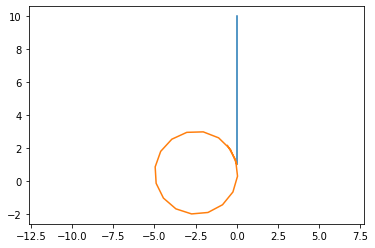

In [6]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1])
plt.show()

### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [7]:
v_c = 1 # m/s
w_c = np.pi / 12 # rad/s

#calculate time taken to finish a quarter turn (pi/2)
t_turn =  int((np.pi/2) / w_c )

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c) , int(5/v_c) , int(8/v_c)

all_w = [0]*t_straight1 + [w_c]*t_turn + \
        [0]*t_straight2 + [w_c]*t_turn + \
        [0]*t_straight3 + [-w_c]*t_turn
all_v = v_c*np.ones_like(all_w)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [8]:
from math import ceil
def get_open_loop_commands(route, vc, wc, dt =1):
    # count = len(route)
    all_w = []
    all_v = []
    for (dir,amt) in route:
        if dir == "straight":
            t_straight = ceil((amt/vc)/dt)
            all_w += [0]*t_straight
        else:
            amt = (amt/180) * np.pi
            t_turn = ceil((amt/wc)/dt)
            if dir == "right":
                all_w += [-wc]*t_turn
            elif dir == "left":
                all_w += [wc]*t_turn
    all_v = v_c*np.ones_like(all_w)
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [9]:
#get_open_loop_commands()
cmd = [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
vc = 1
wc = np.pi/12
all_v, all_w = get_open_loop_commands(cmd,vc,wc)

In [10]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
robot_trajectory.append(list(pose))
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose    
    pose = unicycle_model(pose, v,w)
    # store new pose
    robot_trajectory.append(list(pose))
robot_trajectory = np.array(robot_trajectory)
# store new pose

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


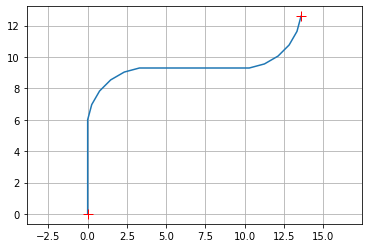

In [11]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1])

#plt.plot( )

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
plt.plot(robot_trajectory[0,0],robot_trajectory[0,1], 'r+', ms=10)
plt.plot(robot_trajectory[-1,0],robot_trajectory[-1,1], 'r+', ms=10)

### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

In [12]:
from math import ceil
def get_open_loop_commands_imp(route, vc_fast, vc_slow, wc, dt =1):
    # count = len(route)
    all_w = []
    all_v = []
    for (dir,amt) in route:
        if dir == "straight":
            t_straight = ceil((amt/vc)/dt)
            all_w += [0]*t_straight
            all_v += [vc_fast] * t_straight
        else:
            amt = (amt/180) * np.pi
            t_turn = ceil((amt/wc)/dt)
            all_v += [vc_slow] * t_turn
            if dir == "right":
                all_w += [-wc]*t_turn
            elif dir == "left":
                all_w += [wc]*t_turn
    # all_v = v_c*np.ones_like(all_w)
    return all_v, all_w

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


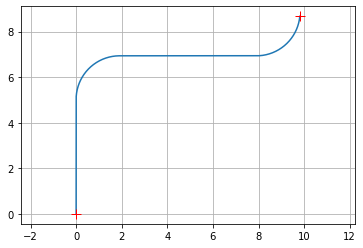

In [13]:
cmd = [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
vc_fast = 1
vc_slow = 0.5
wc = np.pi/12
dt = 0.1  ### Change this to change sampling time (Less dt => Smoother curve)
all_v, all_w = get_open_loop_commands_imp(cmd,vc_fast,vc_slow,wc,dt) ##########

robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
robot_trajectory.append(list(pose))
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose    
    pose = unicycle_model(pose, v,w,dt) ################
    # store new pose
    robot_trajectory.append(list(pose))
robot_trajectory = np.array(robot_trajectory)

# plot robot trajectory
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1])

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
plt.plot(robot_trajectory[0,0],robot_trajectory[0,1], 'r+', ms=10)
plt.plot(robot_trajectory[-1,0],robot_trajectory[-1,1], 'r+', ms=10)